In [1]:
!git clone https://github.com/CASIA-IVA-Lab/FastSAM.git

Cloning into 'FastSAM'...
remote: Enumerating objects: 1221, done.
remote: Counting objects: 100% (386/386), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 1221 (delta 334), reused 305 (delta 305), pack-reused 835
Receiving objects: 100% (1221/1221), 72.46 MiB | 14.10 MiB/s, done.
Resolving deltas: 100% (487/487), done.


In [2]:
!wget https://huggingface.co/spaces/An-619/FastSAM/resolve/main/weights/FastSAM.pt

--2024-05-22 04:00:58--  https://huggingface.co/spaces/An-619/FastSAM/resolve/main/weights/FastSAM.pt
Resolving huggingface.co (huggingface.co)... 13.33.30.114, 13.33.30.23, 13.33.30.76, ...
Connecting to huggingface.co (huggingface.co)|13.33.30.114|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/71/c3/71c3ec5a83f3fc374665cec9240f614262e29088fca1a18732571e13c7084f1b/c0be4e7ddbe4c15333d15a859c676d053c486d0a746a3be6a7a9790d52a9b6d7?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27FastSAM.pt%3B+filename%3D%22FastSAM.pt%22%3B&Expires=1716609659&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcxNjYwOTY1OX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy83MS9jMy83MWMzZWM1YTgzZjNmYzM3NDY2NWNlYzkyNDBmNjE0MjYyZTI5MDg4ZmNhMWExODczMjU3MWUxM2M3MDg0ZjFiL2MwYmU0ZTdkZGJlNGMxNTMzM2QxNWE4NTljNjc2ZDA1M2M0ODZkMGE3NDZhM2JlNmE3YTk3OTBkNTJhOWI2ZDc%7EcmVzcG9uc2UtY29

In [3]:
!pip install -r FastSAM/requirements.txt

  Using cached PyYAML-6.0.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.1 kB)
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of mdit-py-plugins to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of mdit-py-plugins to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 76.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.7/611.7 kB 50.7 MB/s eta 0:00:00
Using cached PyYAML-6.0.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (705 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [6]:
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageDraw, ImageEnhance
import clip
import torch
import numpy as np

In [13]:
def sharpen_contrast(image, factor):
    # Convert the PIL Image to a numpy array
    image_np = np.array(image)
    
    # Define the sharpening kernel
    kernel = np.array([[-1, -1, -1],
                       [-1, 9, -1],
                       [-1, -1, -1]])
    
    # Split the image into its RGB channels
    r, g, b = cv2.split(image_np)
    
    # Apply the sharpening kernel to each channel
    sharpened_r = cv2.filter2D(r, -1, kernel)
    sharpened_g = cv2.filter2D(g, -1, kernel)
    sharpened_b = cv2.filter2D(b, -1, kernel)
    
    # Merge the sharpened channels back into an RGB image
    sharpened_image = cv2.merge([sharpened_r, sharpened_g, sharpened_b])
    
    # Convert the sharpened image back to a PIL Image
    sharpened_image_pil = Image.fromarray(sharpened_image)
    
    # Enhance the contrast
    enhancer = ImageEnhance.Contrast(sharpened_image_pil)
    enhanced_image = enhancer.enhance(factor)
    
    return enhanced_image

#basic increasing contrast
def adjust_contrast(image, factor):
    enhancer = ImageEnhance.Contrast(image)
    return enhancer.enhance(factor)

In [8]:
path_to_jsonl = "../../../novice/"
path_to_images = "../../../novice/images/"

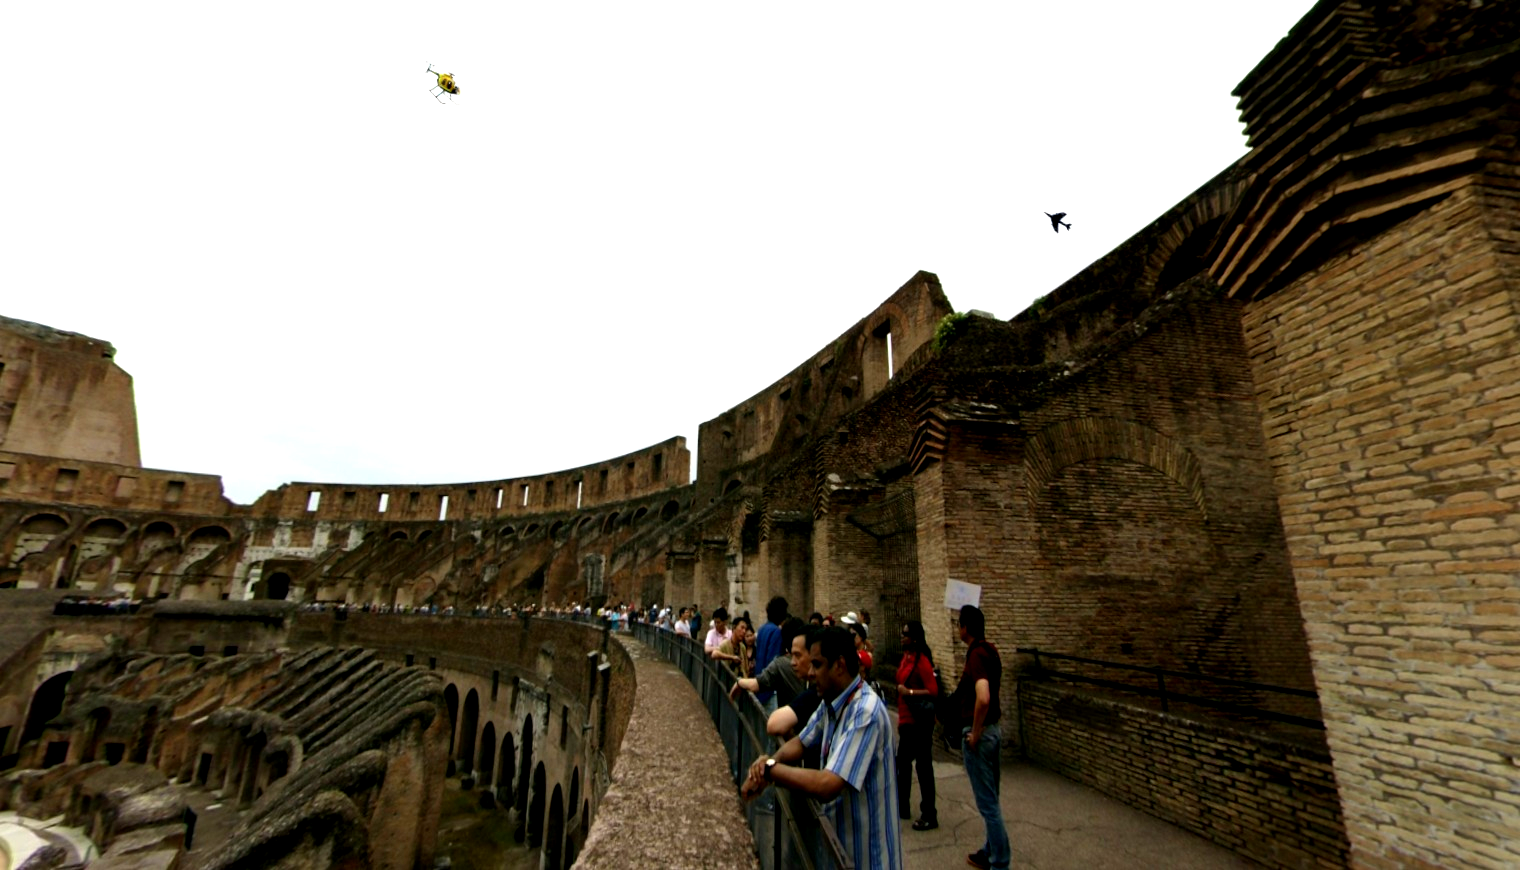

In [14]:
image_path = path_to_images + "image_30.jpg"
image = Image.open(image_path)

image = adjust_contrast(image, 1.5)
image

In [21]:
from FastSAM.fastsam import FastSAM, FastSAMPrompt

In [64]:
model = FastSAM('./FastSAM.pt')
IMAGE_PATH = image_path
DEVICE = 'cuda'
everything_results = model(IMAGE_PATH, device=DEVICE, retina_masks=True, imgsz=1024, conf=0.3, iou=0.4,)
prompt_process = FastSAMPrompt(IMAGE_PATH, everything_results, device=DEVICE)


image 1/1 /home/jupyter/til-24-unholy-trinity/vlm/src/../../../novice/images/image_30.jpg: 608x1024 58 objects, 98.3ms
Speed: 5.1ms preprocess, 98.3ms inference, 12.4ms postprocess per image at shape (1, 3, 1024, 1024)


In [65]:
# text prompt
ann = prompt_process.everything_prompt()
#ann = prompt_process.text_prompt(text='helicopter')

In [153]:
prompt_process.plot(annotations=ann, output_path = 'test.jpg')

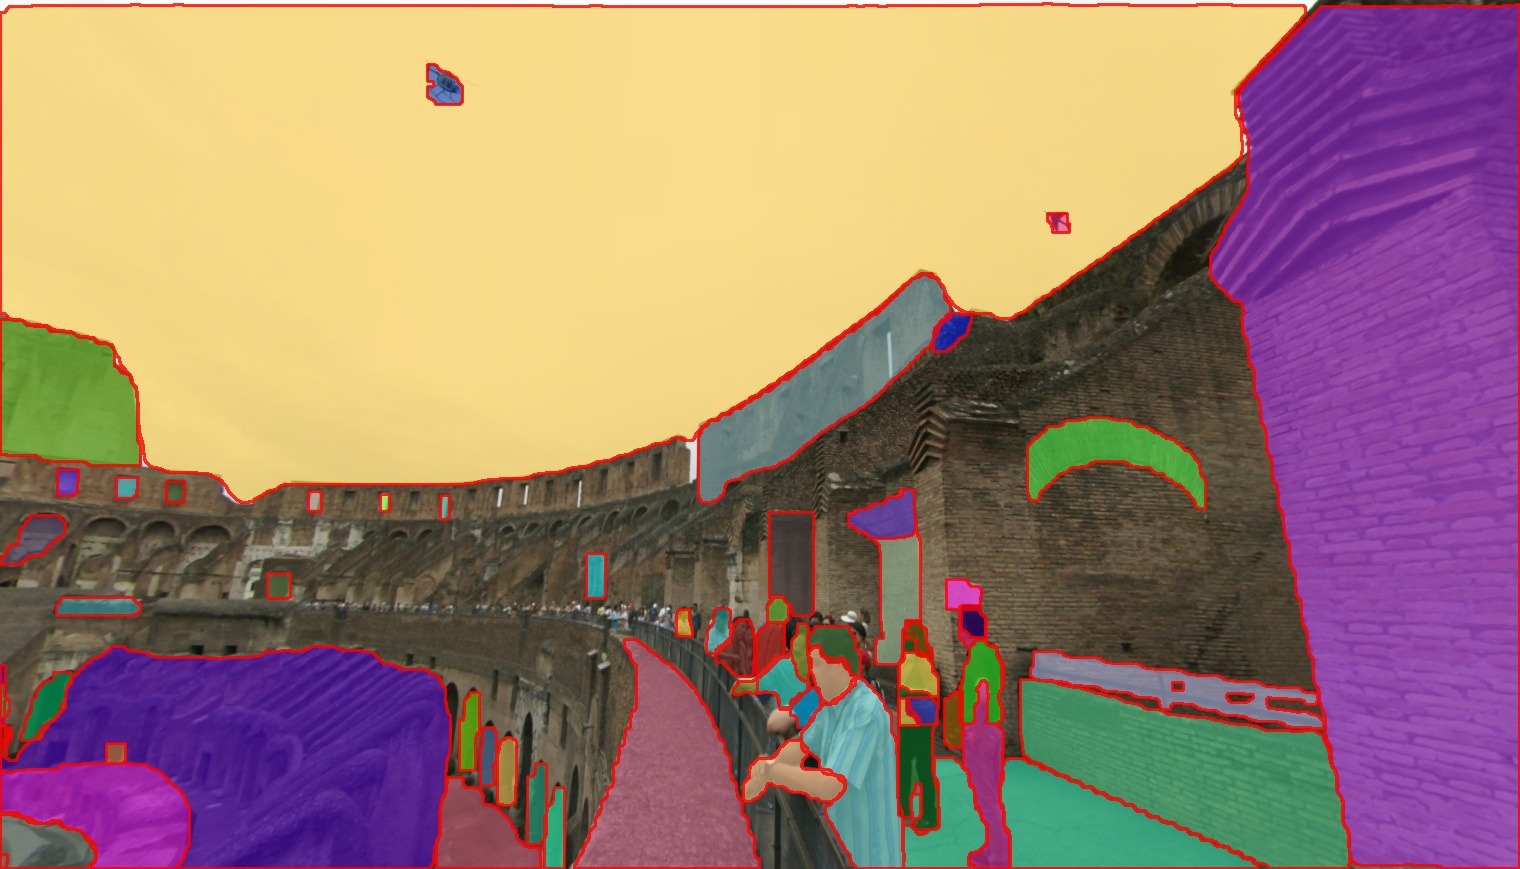

In [154]:
Image.open('test.jpg')

In [151]:
from PIL import Image
import numpy as np

def crop_image_with_mask(image, mask, padding):
    image = np.array(image)
    # Convert the PyTorch tensor to a NumPy array
    mask_np = mask.cpu().numpy() if mask.is_cuda else mask.numpy()
    
    # Find the coordinates of non-zero pixels in the binary mask
    nonzero_coords = np.argwhere(mask_np != 0)
    
    # Calculate the bounding box of the non-zero pixels
    min_row, min_col = np.min(nonzero_coords, axis=0)
    max_row, max_col = np.max(nonzero_coords, axis=0)

    # Define the cropping region with padding
    min_row_pad = max(0, min_row - padding)
    min_col_pad = max(0, min_col - padding)
    max_row_pad = min(image.shape[0], max_row + padding)
    max_col_pad = min(image.shape[1], max_col + padding)

    # Crop the region from the original image using the bounding box
    cropped_image = image[min_row_pad:max_row_pad, min_col_pad:max_col_pad]

    # Resize the cropped image to the desired size
    cropped_image_pil = Image.fromarray(cropped_image).resize((224, 224))

    # Adjust bounding box coordinates for the padded image
    min_row_adjusted = min_row 
    min_col_adjusted = min_col
    max_row_adjusted = max_row 
    max_col_adjusted = max_col

    # Define the bounding box coordinates
    bounding_box = convert_to_left_top_width_height_format((min_row_adjusted, min_col_adjusted, max_row_adjusted, max_col_adjusted))

    return cropped_image_pil, bounding_box

def convert_to_left_top_width_height_format(bounding_box):
    min_row, min_col, max_row, max_col = bounding_box
    left = min_col
    top = min_row
    width = max_col - min_col
    height = max_row - min_row
    return left, top, width, height

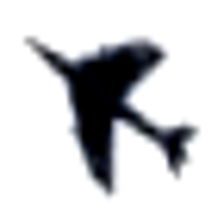

In [152]:
cropped_image, bounding_box = crop_image_with_mask(image, ann[24], 5)
cropped_image

In [149]:
bounding_box

(1045, 212, 26, 20)

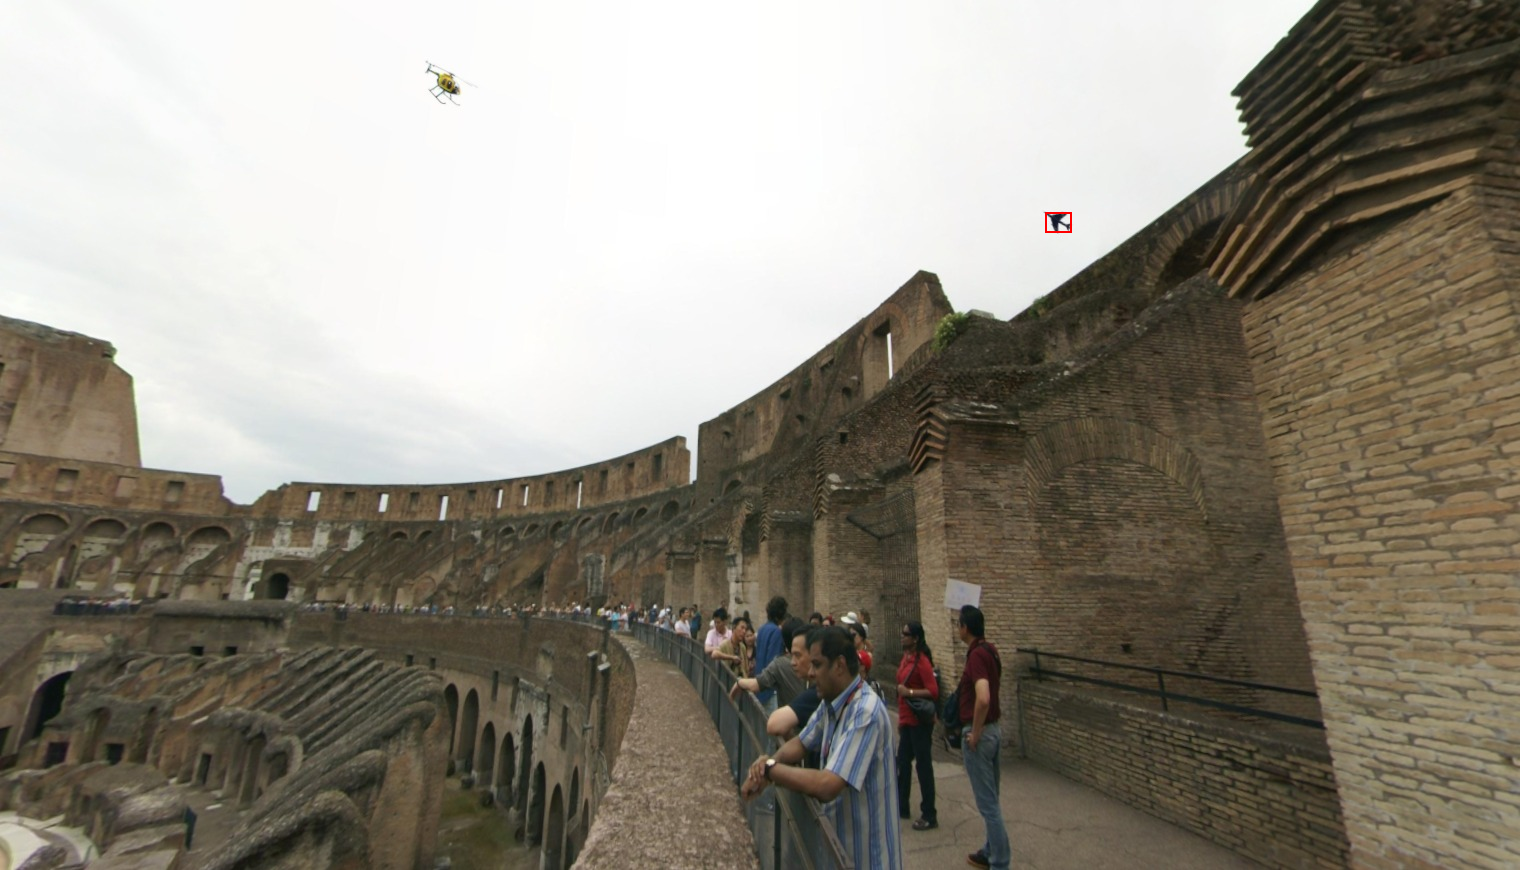

In [150]:
def draw_boxes(image_path, bbox):
    # Open the image
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    
    # Draw bounding boxes

    # Convert XYWH to XYXY format
    x1, y1 = bbox[0], bbox[1]
    x2, y2 = x1 + bbox[2], y1 + bbox[3]
    draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
    
    return image

draw_boxes(image_path, bounding_box)